# Chosen distances for gevtevsimbad

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.neighbors import DistanceMetric
from sklearn import cluster
from sklearn.decomposition.pca import PCA
from sklearn.manifold import TSNE


In [2]:
#metric_function = st.wasserstein_distance

In [3]:
metric_function = lambda x, y : np.sqrt(np.sum(np.multiply(x, y)))/np.sqrt(np.sum(np.multiply(x, x))*np.sum(np.multiply(y, y)))

In [4]:
#path_to_gamma_bins shoud contain an absolute path to your gamma-bins directory
path_to_gamma_bins = os.path.dirname(os.getcwd()) + "/"

In [5]:
#name columns included in the final display
other_names = ['s_MAIN_ID', 's_class', 'gev_1FGL_Name', 'gev_CLASS1', 'tev_fermi_names', 'tev_classes', 'marked']
#from gamma bins directory
path_to_catalog = "markeddata/normalized_spectra.txt"

In [6]:
spectra = pd.read_csv(path_to_gamma_bins +path_to_catalog)
spectra.head()

,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,...,tev_3TeV,tev_10TeV,tev_30TeV,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,0.013537,0.343081,0.020826,0.143005,0.330419,0.0,0.0,0.000000,0.000000,0.0,...,0.012135,0.004136,0.000407,b'SSTGC 519103',Be,b' ',b' ',b'',b'unid',0
1,0.013335,0.013325,0.000805,0.014451,0.004808,0.0,0.0,0.004396,0.019638,0.0,...,0.007655,0.004429,0.002622,b'LS IV -05 11',B,b' ',b'PWN ',b'',b'unid',0
2,0.001682,0.042624,0.002587,0.017767,0.041051,0.0,0.0,0.000000,0.000000,0.0,...,0.001508,0.000514,0.000051,b'GCIRS 1W',B,b' ',b' ',b'',b'unid',0
3,0.011399,0.129145,0.001246,0.070802,0.082033,0.0,0.0,0.000000,0.000000,0.0,...,0.000969,0.000719,0.001111,b'[MCD2010] 18',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
4,0.012809,0.324638,0.019706,0.135318,0.312657,0.0,0.0,0.000000,0.000000,0.0,...,0.011482,0.003914,0.000385,b'GCIRS 8',O,b' ',b' ',b'',b'unid',0


In [7]:
spectrum_columns = spectra.columns[:-len(other_names)]

Computation of pairwise distances (metric - Earth mover's distance (Wasserstein distance))

In [8]:
if type(metric_function) == str:
    dist = DistanceMetric.get_metric(metric_function)
else:
    dist = DistanceMetric.get_metric("pyfunc", func=metric_function)
spectra_distances = dist.pairwise(spectra[spectrum_columns])
#pd.DataFrame(spectra_distances).to_csv(path_to_gamma_bins +"markeddata/gevtev_spectra_EM_distances.txt", index=False)

Vizualization (mapping to 2D-plane)

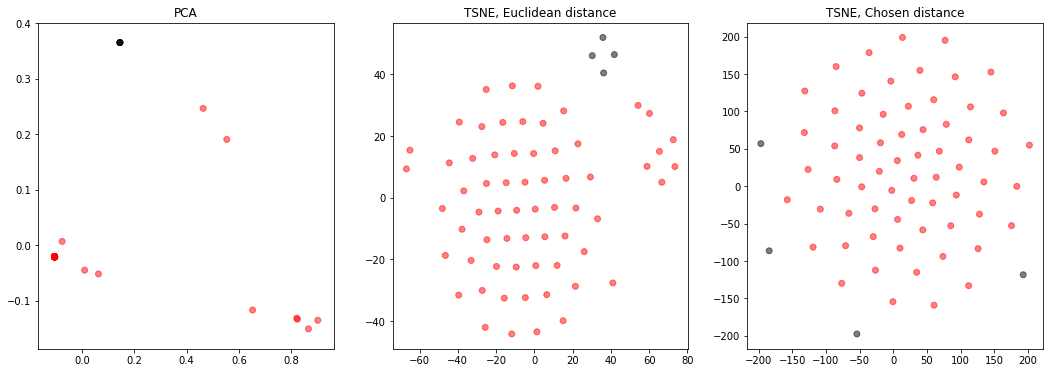

In [9]:
colors = ['red','black']
c = spectra['marked'].apply(lambda x: colors[x])

plt.subplots(figsize=(18, 6))
plt.subplot(131)
plt.title("PCA")
pca = PCA(n_components=2, random_state=42)
spectra_2D = pca.fit_transform(spectra[spectrum_columns])
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

plt.subplot(132)
plt.title("TSNE, Euclidean distance")
tsne = TSNE(n_components=2, random_state=42)
spectra_2D = tsne.fit_transform(spectra[spectrum_columns])
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

plt.subplot(133)
plt.title("TSNE, Chosen distance")
tsne = TSNE(n_components=2, metric=metric_function, random_state=42)
spectra_2D = tsne.fit_transform(spectra[spectrum_columns])
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)
plt.show()

KMeans clustering (with Earth mover's distance metric)

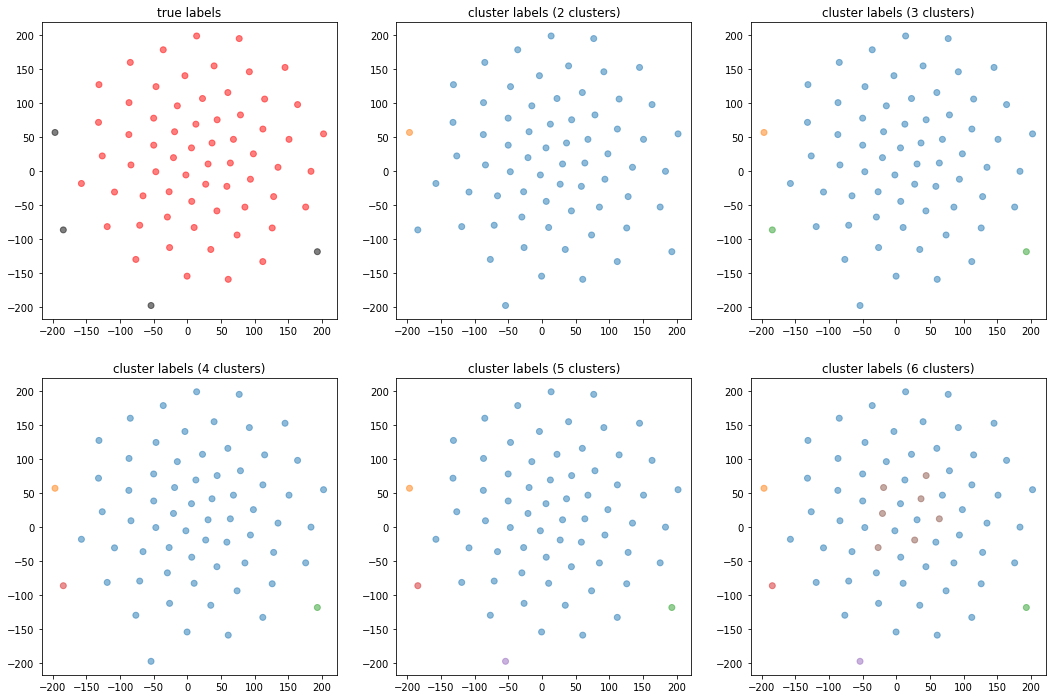

In [10]:
# visualization - tsne with Earth mover's distance
tsne = TSNE(n_components=2, metric=metric_function, random_state=42)
spectra_2D = tsne.fit_transform(spectra[spectrum_columns])

plt.subplots(figsize=(18, 12))
plt.subplot(2, 3, 1)

colors = ['red','black']
c = spectra['marked'].apply(lambda x: colors[x])
plt.title("true labels")
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

for n in range(2, 7):
    kmeans = cluster.KMeans(n_clusters=n, random_state=42)
    cluster_labels = kmeans.fit_predict(spectra_distances)

    plt.subplot(2, 3, n)
    c = [colors[l] for l in cluster_labels]
    plt.title("cluster labels ({} clusters)".format(n))
    plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)
    
plt.show()

In [11]:
n = 5

kmeans = cluster.KMeans(n_clusters=n, random_state=42)
cluster_labels = kmeans.fit_predict(spectra_distances)

spectra['KMeans_clusters_' + str(n)] = cluster_labels
for i in range(n):
    print("{} cluster".format(i))
    display(spectra[spectra['KMeans_clusters_' + str(n)] == i][other_names])

0 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,b'SSTGC 519103',Be,b' ',b' ',b'',b'unid',0
1,b'LS IV -05 11',B,b' ',b'PWN ',b'',b'unid',0
2,b'GCIRS 1W',B,b' ',b' ',b'',b'unid',0
3,b'[MCD2010] 18',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
4,b'GCIRS 8',O,b' ',b' ',b'',b'unid',0
5,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
6,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
8,b'Schulte 21',B0Ve,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',0
10,b'[CHP2004] J095549.8+693934',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
11,b'[MTK2001b] 8',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0


1 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
38,b'2FGL J1019.0-5856',B0Ve,b'1FGL J1018.6-5856 ',b'HMB ',b'1FGL J1018.6-5856',b'bin',1


2 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
7,b'[MT91] 213',B0Ve,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',1


3 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
60,b'V* V479 Sct',B0Ve,b'1FGL J1826.2-1450 ',b'HMB ',b'',b'bin',1


4 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
9,b'LS I +61 303',B0Ve,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1
